In [138]:
import pandas as pd

file_path = 'Actividad - 10,000.xlsx'
df = pd.read_excel(file_path, header=None)
df.dropna(subset=[2], inplace=True)
df = df.iloc[:, :3]
df.columns = ['apartado', 'tipo', 'bien']
df.head()

,apartado,tipo,bien
0,Mobiliario,Mobiliario,SILLON EJECUTIVO RESPALDO MEDIO COLOR NEGRO. N...
1,Mobiliario,Mobiliario,PINTARRON 60X90 (ALTA 20 ENE 1999 MARCA ALFRA).
2,Equipo,Equipo,"MONITOR DE COLOR HP DE 15"", N.D. 017/2002 ALTA..."
3,Mobiliario,Mobiliario,"CESTO DE BASURA ALUMINIO N.D. 007/2005, ALTA 3..."
4,Transporte,Transporte,"AUTOMOVIL FORD ESCORT 1998, PLACAS: HZG1129, N..."


In [139]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stoplist = set(stopwords.words('spanish'))

In [140]:
def limpiar_texto(texto):
    if isinstance(texto, str):
        texto = texto.lower()
        texto = re.sub(r'\d+', '', texto)
        texto = re.sub(r'[^\w\s]', '', texto)
        texto = texto.strip()
        palabras = nltk.word_tokenize(texto)
        palabras_filtradas = [lemmatizer.lemmatize(palabra) for palabra in palabras if palabra not in stoplist]
        return ' '.join(palabras_filtradas)
    return texto

df['bien'] = df['bien'].astype(str)
df['bien_limpio'] = df['bien'].apply(limpiar_texto)
df[['bien', 'bien_limpio']].head()

,bien,bien_limpio
0,SILLON EJECUTIVO RESPALDO MEDIO COLOR NEGRO. N...,sillon ejecutivo respaldo medio color negro nd...
1,PINTARRON 60X90 (ALTA 20 ENE 1999 MARCA ALFRA).,pintarron x alta ene marca alfra
2,"MONITOR DE COLOR HP DE 15"", N.D. 017/2002 ALTA...",monitor color hp nd alta octubre
3,"CESTO DE BASURA ALUMINIO N.D. 007/2005, ALTA 3...",cesto basura aluminio nd alta agosto
4,"AUTOMOVIL FORD ESCORT 1998, PLACAS: HZG1129, N...",automovil ford escort placas hzg serie fabpwr ...


In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['bien_limpio'])

In [142]:
from sklearn.cluster import KMeans

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
df[['bien', 'cluster']].head()

,bien,cluster
0,SILLON EJECUTIVO RESPALDO MEDIO COLOR NEGRO. N...,4
1,PINTARRON 60X90 (ALTA 20 ENE 1999 MARCA ALFRA).,0
2,"MONITOR DE COLOR HP DE 15"", N.D. 017/2002 ALTA...",4
3,"CESTO DE BASURA ALUMINIO N.D. 007/2005, ALTA 3...",0
4,"AUTOMOVIL FORD ESCORT 1998, PLACAS: HZG1129, N...",0


In [143]:
def obtener_item(descripcion):
    palabras = descripcion.split()
    if palabras:
        return palabras[0]
    return 'desconocido'

df['item'] = df['bien_limpio'].apply(obtener_item)
df[['bien', 'bien_limpio', 'item']].head()

,bien,bien_limpio,item
0,SILLON EJECUTIVO RESPALDO MEDIO COLOR NEGRO. N...,sillon ejecutivo respaldo medio color negro nd...,sillon
1,PINTARRON 60X90 (ALTA 20 ENE 1999 MARCA ALFRA).,pintarron x alta ene marca alfra,pintarron
2,"MONITOR DE COLOR HP DE 15"", N.D. 017/2002 ALTA...",monitor color hp nd alta octubre,monitor
3,"CESTO DE BASURA ALUMINIO N.D. 007/2005, ALTA 3...",cesto basura aluminio nd alta agosto,cesto
4,"AUTOMOVIL FORD ESCORT 1998, PLACAS: HZG1129, N...",automovil ford escort placas hzg serie fabpwr ...,automovil


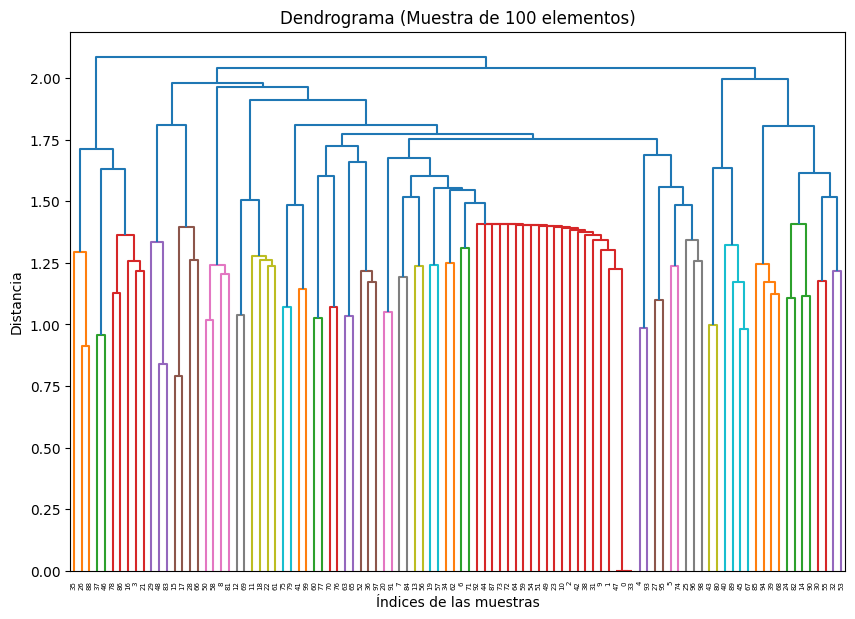

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
X_densa = X.toarray()
np.random.seed(42)
indices_muestra = np.random.choice(X_densa.shape[0], size=100, replace=False)
X_muestra = X_densa[indices_muestra, :]
Z = linkage(X_muestra, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrograma (Muestra de 100 elementos)")
plt.xlabel("Índices de las muestras")
plt.ylabel("Distancia")
plt.show()

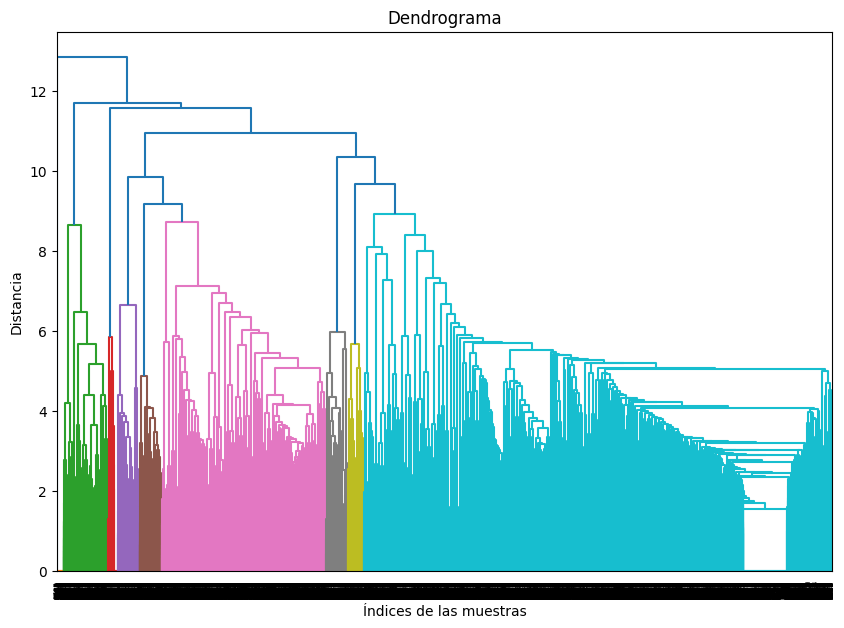

In [145]:
Z = linkage(X_densa, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrograma")
plt.xlabel("Índices de las muestras")
plt.ylabel("Distancia")
plt.show()

In [148]:
distances = np.linspace(0, Z[-1, 2], num=22)
clusters_count = []
print(distances)

[ 0.          0.61158545  1.2231709   1.83475635  2.4463418   3.05792725
  3.6695127   4.28109815  4.8926836   5.50426905  6.1158545   6.72743995
  7.3390254   7.95061085  8.5621963   9.17378175  9.7853672  10.39695265
 11.0085381  11.62012355 12.231709   12.84329444]


In [149]:
for d in distances:
    if d > 0:
        clusters = fcluster(Z, d, criterion='distance')
        clusters_count.append(len(np.unique(clusters)))
print(clusters_count)

[6947, 2275, 1015, 684, 405, 236, 137, 85, 50, 29, 21, 16, 15, 12, 8, 7, 5, 4, 3, 2, 1]


In [158]:
for d, count in zip(distances[1:], clusters_count):
    print(f'Distancia: {d:.2f}, Número de clústeres: {count}')

Distancia: 0.61, Número de clústeres: 6947
Distancia: 1.22, Número de clústeres: 2275
Distancia: 1.83, Número de clústeres: 1015
Distancia: 2.45, Número de clústeres: 684
Distancia: 3.06, Número de clústeres: 405
Distancia: 3.67, Número de clústeres: 236
Distancia: 4.28, Número de clústeres: 137
Distancia: 4.89, Número de clústeres: 85
Distancia: 5.50, Número de clústeres: 50
Distancia: 6.12, Número de clústeres: 29
Distancia: 6.73, Número de clústeres: 21
Distancia: 7.34, Número de clústeres: 16
Distancia: 7.95, Número de clústeres: 15
Distancia: 8.56, Número de clústeres: 12
Distancia: 9.17, Número de clústeres: 8
Distancia: 9.79, Número de clústeres: 7
Distancia: 10.40, Número de clústeres: 5
Distancia: 11.01, Número de clústeres: 4
Distancia: 11.62, Número de clústeres: 3
Distancia: 12.23, Número de clústeres: 2
Distancia: 12.84, Número de clústeres: 1


In [159]:
for num_clusters in clusters_count:
    print(num_clusters)
    cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')
    df[f'cluster_{num_clusters}'] = cluster_labels

6947
2275
1015
684
405
236
137
85
50
29
21
16
15
12
8
7
5
4
3
2
1


In [160]:
from sklearn.cluster import AgglomerativeClustering
for num_clusters in clusters_count:
    print(f'Número de clusters: {num_clusters}')
    agglo = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_labels = agglo.fit_predict(X_densa)
    df[f'cluster_{num_clusters}'] = cluster_labels

Número de clusters: 6947
Número de clusters: 2275
Número de clusters: 1015
Número de clusters: 684
Número de clusters: 405
Número de clusters: 236
Número de clusters: 137
Número de clusters: 85
Número de clusters: 50
Número de clusters: 29
Número de clusters: 21
Número de clusters: 16
Número de clusters: 15
Número de clusters: 12
Número de clusters: 8
Número de clusters: 7
Número de clusters: 5
Número de clusters: 4
Número de clusters: 3
Número de clusters: 2
Número de clusters: 1


In [163]:
try:
    df.to_excel('Actividad 13 - Dataset Final.xlsx', index=False)
    print("Archivo exportado con éxito.")
except Exception as e:
    print(f"Ocurrió un error al exportar el archivo: {e}")

Archivo exportado con éxito.
